# Solution of the Test Assignment from the participant Demin Aleksei

# Part 0: Preparation

Import of libraries and authentication to Google Cloud services

In [ ]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%load_ext google.colab.data_table
project_id = 'datatest-344113'

There are several ids in the data that changed their test group. For cleaner analytics, I excluded them from the data.

In [ ]:
%%bigquery --project datatest-344113

SELECT user_pseudo_id, cnt FROM (
  WITH S AS (SELECT
    user_pseudo_id,
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group
  FROM
    `datatest-344113.Test.events`
  )
  
  SELECT user_pseudo_id, count(distinct ab_group) as cnt
  FROM S
  GROUP BY user_pseudo_id
)
WHERE cnt > 1

,user_pseudo_id,cnt
0,B17A6F5C9A1F4B559E2CA1C99A563455,2
1,C900A6016DEE4D36A2349372C1B6754F,2
2,FF0A85CDAE674A44901A4E4D88CD741A,2
3,5296EAC06F574B22BF30006895539B3F,2
4,AC86B7FE2A094D1E9F1871F017FD0AA7,2
5,4C535BB06C164CA0B4E9A70709B02EE6,2
6,76BEADF78A5D41C1AFE6E0FBC9825793,2


# Part 1: ARPU/ARPPU calculations

Mathematically, ARPU and ARPPU are calculated as: 

ARPU = total revenue / total users

ARPPU = total revenue / total paying users

ARPU_baseline = 778.265 / 9881 = **0.079**

ARPU_a= 519.578 / 10100 = **0.051**

ARPU_b = 563.772 / 10303 = **0.055**

ARPPU_baseline = 778.265 / 50 = **15.565**

ARPPU_a= 519.578 / 63 = **8.247**

ARPPU_b = 563.772 / 58 = **9.720**

In [ ]:
%%bigquery --project datatest-344113

  WITH S AS (SELECT
    user_pseudo_id, event_name, user_ltv, event_value_in_usd,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_id') as product_id, 
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_name') as product_name, 
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group,

  FROM
    `datatest-344113.Test.events`

  WHERE 1=1
  AND user_pseudo_id NOT IN ('B17A6F5C9A1F4B559E2CA1C99A563455',
                            'FF0A85CDAE674A44901A4E4D88CD741A',
                            'C900A6016DEE4D36A2349372C1B6754F',
                            '5296EAC06F574B22BF30006895539B3F',
                            'AC86B7FE2A094D1E9F1871F017FD0AA7',
                            '4C535BB06C164CA0B4E9A70709B02EE6',
                            '76BEADF78A5D41C1AFE6E0FBC9825793')
  )


  SELECT ab_group, 

  sum(event_value_in_usd) / count(distinct user_pseudo_id) as ARPU,
  sum(event_value_in_usd) / count(distinct case when event_name = 'in_app_purchase' then user_pseudo_id end) as ARPPU,

  count(distinct user_pseudo_id) as cnt_all,
  count(distinct case when event_name = 'in_app_purchase' then user_pseudo_id end) as cnt_paid,
  sum(event_value_in_usd) as sum_purchased

  FROM S
  WHERE 1=1
  and ab_group is not null
  GROUP BY ab_group
  ORDER BY ab_group
  

,ab_group,ARPU,ARPPU,cnt_all,cnt_paid,sum_purchased
0,0,0.078764,15.565310,9881,50,778.265520
1,1,0.051443,8.247268,10100,63,519.577877
2,2,0.054719,9.720200,10303,58,563.771584


# Part 2: Users' first purchases count in each group, grouped by product type

Aggregating by A/B test group and product_id got this table of count of first purchases

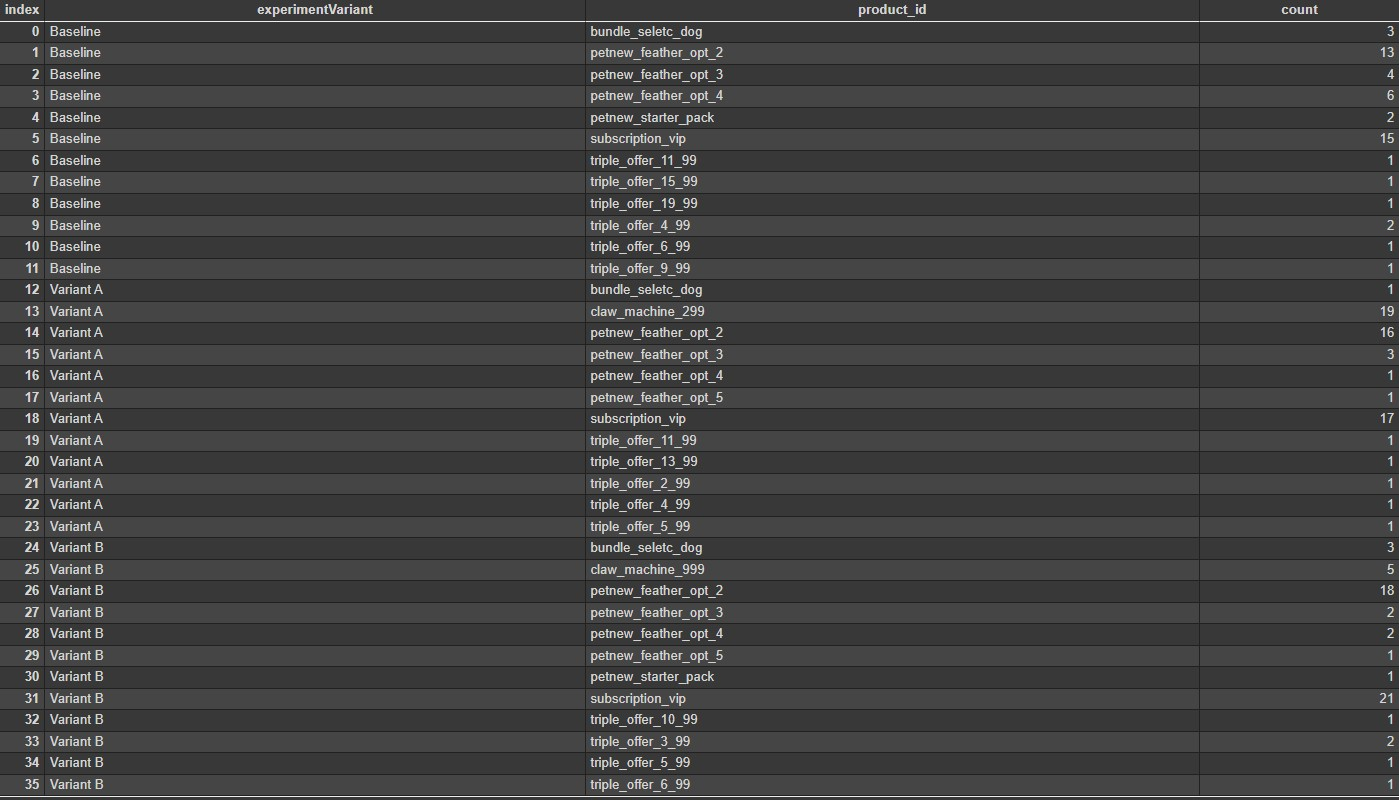

In [ ]:
%%bigquery --project datatest-344113

  SELECT
  case when ab_group='0' then 'Baseline' 
        when ab_group='1' then 'Variant A'
          else 'Variant B' end as experimentVariant,
  product_id,
  count(*) as count

  FROM
  (
  WITH S AS (SELECT
    user_pseudo_id, event_timestamp, event_name, user_ltv, event_value_in_usd,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_id') as product_id, 
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_name') as product_name, 
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group,

  FROM
    `datatest-344113.Test.events`

  WHERE 1=1
  AND user_pseudo_id NOT IN ('B17A6F5C9A1F4B559E2CA1C99A563455',
                            'FF0A85CDAE674A44901A4E4D88CD741A',
                            'C900A6016DEE4D36A2349372C1B6754F',
                            '5296EAC06F574B22BF30006895539B3F',
                            'AC86B7FE2A094D1E9F1871F017FD0AA7',
                            '4C535BB06C164CA0B4E9A70709B02EE6',
                            '76BEADF78A5D41C1AFE6E0FBC9825793')
  )


  SELECT user_pseudo_id, event_timestamp, product_id, ab_group,
  ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp ASC) AS purchase_number

  FROM S
  WHERE 1=1
  and ab_group is not null
  and event_name = 'in_app_purchase'
  )

  WHERE purchase_number = 1
  GROUP BY ab_group, product_id
  ORDER BY ab_group, product_id

,experimentVariant,product_id,count
0,Baseline,bundle_seletc_dog,3
1,Baseline,petnew_feather_opt_2,13
2,Baseline,petnew_feather_opt_3,4
3,Baseline,petnew_feather_opt_4,6
4,Baseline,petnew_starter_pack,2
5,Baseline,subscription_vip,15
6,Baseline,triple_offer_11_99,1
7,Baseline,triple_offer_15_99,1
8,Baseline,triple_offer_19_99,1
9,Baseline,triple_offer_4_99,2


# Part 3: 1D and 3D Retentions cohorts

Mathematically, N-Day Retention is calculated as the number of people playing exactly N days after their first session, divided by the number of new users exactly N days ago

But in the test dataset `datatest-344113.Test.events` ab-groups do not have 'first_open' events  at all

In [ ]:
%%bigquery --project datatest-344113

  WITH S AS (SELECT
    user_pseudo_id, event_name,
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group,

  FROM
    `datatest-344113.Test.events`
  )

  SELECT ab_group, count(*) as count_all, count(distinct user_pseudo_id) as count_ids
  FROM S
  WHERE event_name = 'first_open'
  GROUP BY ab_group

,ab_group,count_all,count_ids
0,None,11043,10782


In [ ]:
%%bigquery --project datatest-344113

  WITH S AS (SELECT
    user_pseudo_id, event_name,
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group,

  FROM
    `datatest-344113.Test.events`
  )

  SELECT count(*) as count
  FROM S
  WHERE event_name = 'first_open'
    and ab_group is not null

,count
0,0


Unfortunately, I am doing this test assignment on the weekend and I do not have the opportunity to clarify info about the input data.

So in the current solution, I performed calculations on entire dataset.

If I'm not mistaken and there really is not enough data, you can send a new dataset. I will quickly make new calculations on my code.

Counts of 'first_event' events by days

In [ ]:
%%bigquery --project datatest-344113

SELECT
    event_date, count(distinct user_pseudo_id) as cnt_users
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'first_open'
  GROUP BY event_date
  ORDER BY event_date

,event_date,cnt_users
0,20220301,1147
1,20220302,1155
2,20220303,1157
3,20220304,1503
4,20220305,1912
5,20220306,1754
6,20220307,1110
7,20220308,1045


In [ ]:
%%bigquery --project datatest-344113

  WITH S AS (SELECT
    user_pseudo_id, event_timestamp, event_date, event_name, user_ltv, event_value_in_usd,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_id') as product_id, 
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_name') as product_name, 
    (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group

  FROM
    `datatest-344113.Test.events`

  WHERE 1=1
  AND user_pseudo_id NOT IN ('B17A6F5C9A1F4B559E2CA1C99A563455',
                             'FF0A85CDAE674A44901A4E4D88CD741A',
                             'C900A6016DEE4D36A2349372C1B6754F',
                             '5296EAC06F574B22BF30006895539B3F',
                             'AC86B7FE2A094D1E9F1871F017FD0AA7',
                             '4C535BB06C164CA0B4E9A70709B02EE6',
                             '76BEADF78A5D41C1AFE6E0FBC9825793')
  )


  SELECT
  COUNT(DISTINCT user_pseudo_id) as cnt_overall,
  COUNT(DISTINCT CASE WHEN event_date = '20220301' THEN user_pseudo_id END) as cnt_0301,
  COUNT(DISTINCT CASE WHEN event_date = '20220302' THEN user_pseudo_id END) as cnt_0302,
  COUNT(DISTINCT CASE WHEN event_date = '20220303' THEN user_pseudo_id END) as cnt_0303,
  COUNT(DISTINCT CASE WHEN event_date = '20220304' THEN user_pseudo_id END) as cnt_0304,
  COUNT(DISTINCT CASE WHEN event_date = '20220305' THEN user_pseudo_id END) as cnt_0305,
  COUNT(DISTINCT CASE WHEN event_date = '20220306' THEN user_pseudo_id END) as cnt_0306,
  COUNT(DISTINCT CASE WHEN event_date = '20220307' THEN user_pseudo_id END) as cnt_0307,
  COUNT(DISTINCT CASE WHEN event_date = '20220308' THEN user_pseudo_id END) as cnt_0308
    FROM S
  WHERE 1=1
  --and ab_group = '2'
  and event_name = 'first_open'
  --GROUP BY ab_group

,cnt_overall,cnt_0301,cnt_0302,cnt_0303,cnt_0304,cnt_0305,cnt_0306,cnt_0307,cnt_0308
0,10780,1147,1155,1156,1503,1912,1753,1110,1045


Code for Reteniton calculations

In [ ]:
%%bigquery --project datatest-344113

SELECT count(*) as cnt_all, count(distinct t1.user_pseudo_id) as cnt_unique_id

FROM
(
SELECT
    user_pseudo_id, event_date as dt_first
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'first_open'
  and event_date = '20220301' --exclude this filter from query if you want to see overall numbers
) t1
JOIN
(
SELECT
  user_pseudo_id, event_date
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'session_start'
  GROUP BY user_pseudo_id, event_date
) t2
ON t1.user_pseudo_id = t2.user_pseudo_id and cast(t2.event_date AS int) = cast(t1.dt_first AS int) + 1 --+1,+2,+3 days

,cnt_all,cnt_unique_id
0,419,417


Tables of 1D and 3D Retention - [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1OIdMbJxM44HgknZwH0Pw8i3raGQFNXqbIQz6nuMWmN0/edit?usp=sharing)

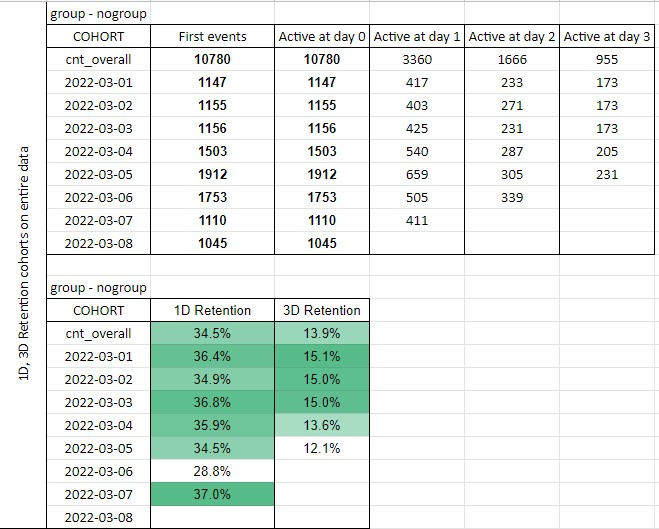

------------

Assuming that the first session in dataset = first_open we can calculate this 1D, 3D retentions

In [ ]:
%%bigquery --project datatest-344113

SELECT count(*) as cnt_all, count(distinct t1.user_pseudo_id) as cnt_unique_id

FROM
(
SELECT * 
  FROM (
      SELECT
        user_pseudo_id, event_date as dt_first,
        ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_date ASC) AS rn,
        (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') as ab_group
      FROM
        `datatest-344113.Test.events`
      WHERE event_name = 'session_start'
      )
  WHERE rn = 1 and ab_group = '2' --group 0,1,2
) t1
JOIN
(
SELECT
  user_pseudo_id, event_date
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'session_start'
  GROUP BY user_pseudo_id, event_date
) t2
ON t1.user_pseudo_id = t2.user_pseudo_id and cast(t2.event_date AS int) = cast(t1.dt_first AS int) + 3 --+1,+2,+3 days

,cnt_all,cnt_unique_id
0,946,946


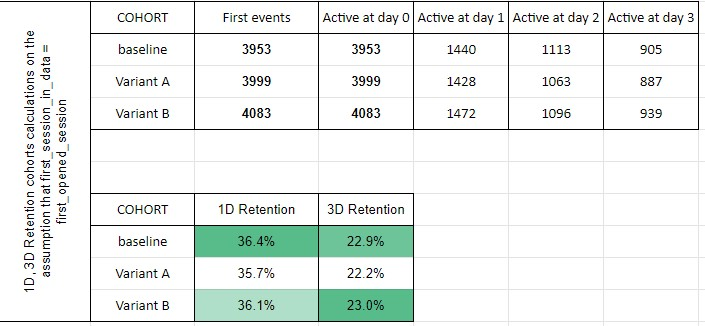

# Part 4: Valuable insights about the experiment

Here what can we see from Bayesian test:

*  **ARPPU B to A:** If we select variant B, and our choice is correct (probability = 82%) we can expect uplift 1.6 in ARPPU. But if it is actually worse (probability=18%) we can expect loss 0.16 in ARPPU

*  **ARPPU B to baseline:** If we select variant B, and our choice is correct (probability = 1%) we can expect uplift 0.06 in ARPPU. But if it is actually worse (probability = 99%) we can expect loss 5.8 in ARPPU


*  **Conversion A to B:** If we select variant A, and our choice is correct (probability = 71%) we can expect uplift 0.08 in conversion. But if it is actually worse (probability=29%) we can expect loss 0.019 in conversion


*  **Conversion A to baseline:** If we select variant A, and our choice is correct (probability = 87%) we can expect uplift 0.13 in conversion. But if it is actually worse (probability = 13%) we can expect loss 0.007 in conversion.


*  **ARPPU A to baseline:** If we select variant A, and our choice is correct (probability < 1%) we can expect uplift 0.0002 in ARPPU. But if it is actually worse (probability > 99%) we can expect loss 7.3 in ARPPU


**Conclusion - both variants with high probability will lead to a decrease in ARPPU. With Variant A with high probability we can expect to gain 0.12 resulting in 0.62 conversion (but losing approx. 7$ in ARPPU).**

---



To increase the success of the AB test, it is advisable to extend the duration of the test from 7 to 14 days.


Also there are some metrics which can contain insights (but I don't have enogh time to check them):


*   Sessions Per User
*   Sessions Per Converted User
*   Events Per User
*   Events Per Converted User

Also, on the data from the assignment, it is possible to build a predictive model of propensity to buy. But the free version of Google Cloud does not provide sufficient resources to train even the simplest model. 

Simple conversion -  purchase_events/total_sessions - variant A is significantly better (CR = 0.5%, p-value = 0.014)

This test confirms the idea above

In [ ]:
%%bigquery --project datatest-344113

SELECT
  'baseline' as experimentVariant, count(*) as count_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'session_start'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '0'
UNION ALL
SELECT
  'Variant_A' as experimentVariant, count(*) as count_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'session_start'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '1'
UNION ALL    
SELECT
  'Variant_B' as experimentVariant, count(*) as count_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'session_start'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '2'


,experimentVariant,count_sessions
0,Variant_A,25196
1,baseline,25278
2,Variant_B,25282


In [ ]:
%%bigquery --project datatest-344113

SELECT
  'baseline' as experimentVariant, count(*) as count_purchase_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'in_app_purchase'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '0'
UNION ALL
SELECT
  'Variant_A' as experimentVariant, count(*) as count_purchase_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'in_app_purchase'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '1'
UNION ALL    
SELECT
  'Variant_B' as experimentVariant, count(*) as count_purchase_sessions
  FROM
    `datatest-344113.Test.events`
  WHERE event_name = 'in_app_purchase'
    and (SELECT value.string_value FROM UNNEST(user_properties) WHERE key='firebase_exp_56') = '2'

,experimentVariant,count_purchase_sessions
0,Variant_B,87
1,baseline,87
2,Variant_A,126



Product claw_machine_new is missing in the data proposed for analysis. Thus, it was not possible to make analytics related to this product

In [ ]:
%%bigquery --project datatest-344113

SELECT
    distinct
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key='product_id') as product_id, 
  FROM
    `datatest-344113.Test.events`
ORDER BY product_id

,product_id
0,None
1,bundle_seletc_dog
2,claw_machine_299
3,claw_machine_999
4,monthly_diamond_bundle
5,petnew_feather_opt_2
6,petnew_feather_opt_3
7,petnew_feather_opt_4
8,petnew_feather_opt_5
9,petnew_starter_pack
